In [14]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import plotly
import gmaps
import json
import seaborn as sns
import config

# Import gkey for Google Maps API
from config import gkey
gmaps.configure(api_key = gkey)

# Import lat and long lists
from latitude_longitude import lat
from latitude_longitude import lon 

#from config import api_key
from config import gkey

# Create dataframes from csv files
df_2017 = pd.read_csv("Data/PrescribingRate2017.csv", encoding="ISO-8859-1")
df_2016 = pd.read_csv("Data/PrescribingRate2016.csv", encoding="ISO-8859-1")
df_2015 = pd.read_csv("Data/PrescribingRate2015.csv", encoding="ISO-8859-1")
df_2014 = pd.read_csv("Data/PrescribingRate2014.csv", encoding="ISO-8859-1")
df_2013 = pd.read_csv("Data/PrescribingRate2013.csv", encoding="ISO-8859-1")
df_2012 = pd.read_csv("Data/PrescribingRate2012.csv", encoding="ISO-8859-1")
df_2011 = pd.read_csv("Data/PrescribingRate2011.csv", encoding="ISO-8859-1")
df_2010 = pd.read_csv("Data/PrescribingRate2010.csv", encoding="ISO-8859-1")
df_2009 = pd.read_csv("Data/PrescribingRate2009.csv", encoding="ISO-8859-1")
df_2008 = pd.read_csv("Data/PrescribingRate2008.csv", encoding="ISO-8859-1")
df_2007 = pd.read_csv("Data/PrescribingRate2007.csv", encoding="ISO-8859-1")
df_2006 = pd.read_csv("Data/PrescribingRate2006.csv", encoding="ISO-8859-1")
df_uszips = pd.read_csv("Data/uszips.csv", encoding="ISO-8859-1",converters={'zip': '{:0>5}'.format}) #this format adds zeros to zip if >5 digits
df_deaths = pd.read_csv("Data/CDC_Data.csv", encoding="ISO-8859-1")
df_opioid_deaths = pd.read_csv("Data/CDC_Overdose_Deaths_1999_to_2017_OPIOID ONLY.csv", encoding="ISO-8859-1")
df_prescribing_totals = pd.read_csv("Data/PrescribingTotals2006to2017.csv", encoding="ISO-8859-1")


#-----------------------------------------------------#
#------------Data Munging/Cleaning/Merging------------#
#-----------------------------------------------------#

# First check that files being merged have same column header names
list(df_2017) == list(df_2016)
list(df_2017)

# Rename columns of 2017 dataframe to match for merge
columns_renamed = {'Year': 'Year',
 'County': 'County',
 'State': 'State',
 'State/County FIPS Code': 'FIPS County Code',
 'Opioid Prescribing Rate per 100': 'Opioid Prescribing Rate per 100'}

df_2017 = df_2017.rename(columns=columns_renamed)
list(df_2017)

# Check that column names across all dataframes are uniform
list(df_2017) == list(df_2016) == list(df_2015) == list(df_2014) == list(df_2013) == list(df_2012) == list(df_2011) == list(df_2010) \
== list(df_2009) == list(df_2008) == list(df_2007) == list(df_2006)

# Since column names are all the same, we can use concatinate to merge all files
merged_df = pd.concat([df_2017, df_2016, df_2015, df_2014, df_2013, df_2012, df_2011, df_2010, \
                      df_2009, df_2008, df_2007, df_2006])

# Clean uszips data, and combine it with merged df to create df with both FIPS and ZIP
df_uszips.head()

# Create dataframe with only variables we want to use
df_uszips_clean = df_uszips[['zip','city','county_fips','county_name']]
df_uszips_clean.head()

list(merged_df)

# Change column names to match with the merged data on the column we want to merge with
columns_renamed = {'zip': 'Zip Code',
 'city': 'City',
 'county_fips': 'FIPS County Code',
 'county_name': 'County Name'}

df_uszips_clean = df_uszips_clean.rename(columns=columns_renamed)
list(df_uszips_clean)

# Now merge the Zip Code data with the Merged prescription rate dataframe
zip_merged = pd.merge(merged_df, df_uszips_clean, on="FIPS County Code")

# Now check for missing data and drop rows
zip_merged.count()
zip_merged = zip_merged.dropna(how='any')
zip_merged.count()

# Sort by each column to check first and last data from each column

zip_merged.sort_values("Year", ascending=False)
zip_merged.sort_values("Year", ascending=True)

zip_merged.sort_values("County", ascending=False)
zip_merged.sort_values("County", ascending=True)

zip_merged.sort_values("State", ascending=False)
zip_merged.sort_values("State", ascending=True)

zip_merged.sort_values("FIPS County Code", ascending=False)
zip_merged.sort_values("FIPS County Code", ascending=True)

# When sorting this column, we can see that there are strings/ non-numeric values, by getting an error
#........zip_merged.sort_values("Opioid Prescribing Rater per 100", ascending=False)
# Drop all rows from Opioid column that are non-integers

zip_merged["Opioid Prescribing Rate per 100"] = pd.to_numeric(zip_merged["Opioid Prescribing Rate per 100"], errors='coerce')
zip_merged["Opioid Prescribing Rate per 100"].value_counts()
new_zip_merged = zip_merged.dropna()
new_zip_merged.info()

new_zip_merged.sort_values("Opioid Prescribing Rate per 100", ascending=True)
new_zip_merged.sort_values("Opioid Prescribing Rate per 100", ascending=True)

new_zip_merged.sort_values("Zip Code", ascending=False)
new_zip_merged.sort_values("Zip Code", ascending=True)

new_zip_merged.sort_values("City", ascending=False)
new_zip_merged.sort_values("City", ascending=True)

new_zip_merged.sort_values("County Name", ascending=False)
new_zip_merged.sort_values("County Name", ascending=True)

# Double check new count of rows from cleaned dataframe
new_zip_merged.count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378478 entries, 0 to 394686
Data columns (total 8 columns):
Year                               378478 non-null int64
County                             378478 non-null object
State                              378478 non-null object
FIPS County Code                   378478 non-null int64
Opioid Prescribing Rate per 100    378478 non-null float64
Zip Code                           378478 non-null object
City                               378478 non-null object
County Name                        378478 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 26.0+ MB


Year                               378478
County                             378478
State                              378478
FIPS County Code                   378478
Opioid Prescribing Rate per 100    378478
Zip Code                           378478
City                               378478
County Name                        378478
dtype: int64

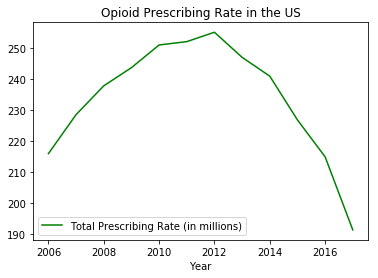

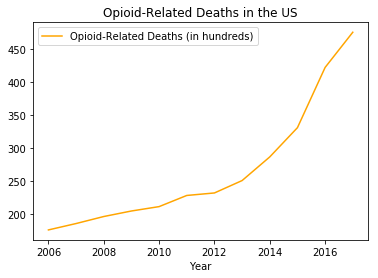

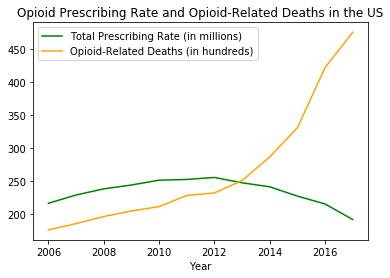

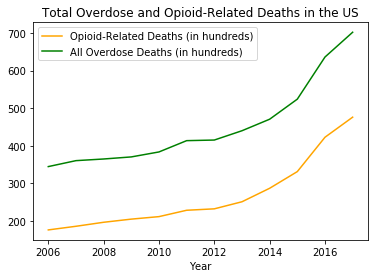

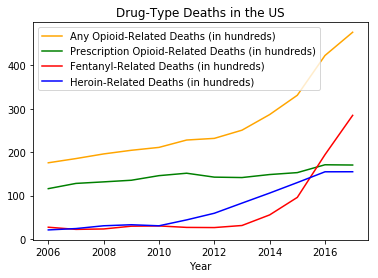

In [15]:
#--------------------------------------------------------#
#------------Create Graphs from combined data------------#
#--------------------------------------------------------#

##### Prescription Data #####

# Create x and y variables for prescription graph
# First, want to look at total prescription rates by YEAR
year = df_prescribing_totals['Year']
# Second, need to convert number string to float
df_prescribing_totals['Total Prescriptions'] = df_prescribing_totals['Total Prescriptions'].str.replace(",","").astype(float)
rx_totals = df_prescribing_totals['Total Prescriptions']
rx_totals = rx_totals/1000000


##### Opioid Death Data #####

# For opioid deaths, drop the years that are not included in prescription data, and keep only 2006 to 2017
df_new_opioid = df_opioid_deaths.drop(df_opioid_deaths.index[[0,1,2,3,4,5,6,19]])
# Group deaths by year
opioid_deaths_grouped = df_new_opioid.groupby(['Year'])
# Create different variables for type of death
any_opioid = opioid_deaths_grouped["Any Opioid1"].sum()/100
total_overdose = opioid_deaths_grouped["Total Overdose Deaths"].sum()/100
prescription_opioid = opioid_deaths_grouped["Prescription Opioids2"].sum()/100
synth_narcotics = opioid_deaths_grouped["Other Synthetic Narcotics (fentanyl)3"].sum()/100
heroin = opioid_deaths_grouped["Heroin4"].sum()/100


# Plot the graph of Opioid Prescribing Rate in the US
plt.plot(year, rx_totals, color='g', label='Total Prescribing Rate (in millions)')
plt.xlabel('Year')
plt.title('Opioid Prescribing Rate in the US')
plt.legend()
plt.savefig("Images/OpioidPrescriptionsByYear.png")
plt.show()

# Plot the graph for Opioid-Related Deaths in the US
plt.plot(year, any_opioid, color='orange', label='Opioid-Related Deaths (in hundreds)')
plt.xlabel('Year')
plt.title('Opioid-Related Deaths in the US')
plt.legend()
plt.savefig("Images/OpioidDeathsByYear.png")
plt.show()

# Plot the graph for Opioid Prescribing Rate and Opioid-Related Deaths in the US
plt.plot(year, rx_totals, color='g', label='Total Prescribing Rate (in millions)')
plt.plot(year, any_opioid, color='orange', label='Opioid-Related Deaths (in hundreds)')
plt.xlabel('Year')
plt.title('Opioid Prescribing Rate and Opioid-Related Deaths in the US')
plt.legend()
plt.savefig("Images/OpioidPrescriptionsandDeathsByYear.png")
plt.show()

# Plot graph for Total Overdose and Opioid-Related Deaths in the US
plt.plot(year, any_opioid, color='orange', label='Opioid-Related Deaths (in hundreds)')
plt.plot(year, total_overdose, color='g', label='All Overdose Deaths (in hundreds)')
plt.xlabel('Year')
plt.title('Total Overdose and Opioid-Related Deaths in the US')
plt.legend()
plt.savefig("Images/OpioidOverdoseByYear.png")
plt.show()

# Plot Graph for Drug-Type Deaths in US
plt.plot(year, any_opioid, color='orange', label='Any Opioid-Related Deaths (in hundreds)')
plt.plot(year, prescription_opioid, color='g', label='Prescription Opioid-Related Deaths (in hundreds)')
plt.plot(year, synth_narcotics, color='r', label='Fentanyl-Related Deaths (in hundreds)')
plt.plot(year, heroin, color='b', label='Heroin-Related Deaths (in hundreds)')
plt.xlabel('Year')
plt.title('Drug-Type Deaths in the US')
plt.legend()
plt.savefig("Images/DrugDeathsByYear.png")
plt.show()

In [12]:
#------------------------------#
#------Creating Heat Maps------#
#------------------------------#

# Create dataframes by year that now include ZIP, City and County Names
new_2017_df = new_zip_merged[new_zip_merged["Year"] == 2017]
new_2016_df = new_zip_merged[new_zip_merged["Year"] == 2016]
new_2015_df = new_zip_merged[new_zip_merged["Year"] == 2015]
new_2014_df = new_zip_merged[new_zip_merged["Year"] == 2014]
new_2013_df = new_zip_merged[new_zip_merged["Year"] == 2013]
new_2012_df = new_zip_merged[new_zip_merged["Year"] == 2012]
new_2011_df = new_zip_merged[new_zip_merged["Year"] == 2011]
new_2010_df = new_zip_merged[new_zip_merged["Year"] == 2010]
new_2009_df = new_zip_merged[new_zip_merged["Year"] == 2009]
new_2008_df = new_zip_merged[new_zip_merged["Year"] == 2008]
new_2007_df = new_zip_merged[new_zip_merged["Year"] == 2007]
new_2006_df = new_zip_merged[new_zip_merged["Year"] == 2006]

# Find differences in prescriptions from 2006 to 2012, when there was a peak 
# Groupby county, find mean per county, calculate difference, then create new dataframe including locations

groupby_county_2012 = new_2012_df.groupby("County")
groupby_county_2006 = new_2006_df.groupby("County")
prescriptions_2012 = groupby_county_2012['Opioid Prescribing Rate per 100'].mean()
prescriptions_2006 = groupby_county_2006['Opioid Prescribing Rate per 100'].mean()
prescriptions_diff = prescriptions_2012 - prescriptions_2006
prescriptions_2012 = prescriptions_2012.reset_index()
prescriptions_new = prescriptions_2012.set_index('County')
prescriptions_new['Differences'] = prescriptions_diff
prescriptions_new

# Previously called lat & lon from GoogleMaps API were saved into a separate file and imported in dependencies
prescriptions_new['Latitude'] = lat
prescriptions_new['Longitude'] = lon
prescriptions_clean = prescriptions_new.dropna()
prescriptions_clean

differences = []
for row in prescriptions_clean["Differences"]:
    if row <=0: 
        differences.append(0)
    else:
        differences.append(row)
prescriptions_clean['Differences'] = differences   


# Clean prescriptions dataframe to drop null values 
counties = new_2012_df['County'].unique()
locations_df = pd.DataFrame({"Latitude": lat, "Longitude": lon, "Counties": counties})
locations_df.head()
locations_clean = locations_df.dropna()
len(locations_clean)


# Create variables to plot using cleaned dataframe
locations_df_clean = prescriptions_clean[['Latitude','Longitude']]
prescription_diffs = prescriptions_clean['Differences']

# Plot heatmap!
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations_df_clean, 
                                 weights = prescription_diffs, 
                                 dissipating = False, 
                                 max_intensity = None, 
                                 point_radius = 1,
                                 )
heat_layer.gradient = [
'white',
'gray',
'blue']

fig.add_layer(heat_layer)
fig


C:\Users\T430s\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Figure(layout=FigureLayout(height='420px'))

In [11]:
#----------Display Percentages-----------#

# Percent of Opioid over Total Overdose Deaths
total_deaths = opioid_deaths_grouped["Total Overdose Deaths"].sum()
opioid_deaths = opioid_deaths_grouped["Any Opioid1"].sum()
percent_deaths = opioid_deaths/total_deaths
percent_deaths = percent_deaths.map("{:.2%}".format)
percent_deaths

Year
2006    50.97%
2007    51.42%
2008    53.72%
2009    55.19%
2010    55.02%
2011    55.11%
2012    55.81%
2013    56.96%
2014    60.88%
2015    63.15%
2016    66.40%
2017    67.77%
dtype: object